In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
trainSet = dataset['2017':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
# Hyper paramerters
no_neurons = 60
drop_out = 0.2

# Normalize each symbols independently

In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(data, s, is_test):
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data)
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = data[i+j-1,0]
                    if is_test:
                        test_set[s]['X'][j].append(x)
                        test_set[s]['Y'][j].append(k)
                    else:
                        train_set[s]['X'][j].append(x)
                        train_set[s]['Y'][j].append(k)
                    if k == data[l-1,0]:
                        stop_append[j] =True

In [7]:
test_set = {}
train_set = {}
scaler = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    # normalize data
    sc = MinMaxScaler(feature_range=(0,1))     
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    sc.partial_fit(train_stock)
    if len(test_stock):
        sc.partial_fit(test_stock)
        test_stock_scaled = sc.transform(test_stock)
    train_stock_scaled = sc.transform(train_stock)
    scaler[s] = sc
    
    # Define train_set test_set
    train_set.update({s:{
        'X':{},
        'Y':{}
    }})
    test_set.update({s:{
        'X':{},
        'Y':{}
    }})
    for i in prediction_intervals:
        train_set[s]['X'][i] = []
        train_set[s]['Y'][i] = []
        if len(test_stock):
            test_set[s]['X'][i] = []
            test_set[s]['Y'][i] = []
    if len(test_stock):
        make_samples(test_stock_scaled, s, is_test = True)
    make_samples(train_stock_scaled, s, is_test = False)

In [8]:
# Convert into numpy array
for s in train_set:
    for i in train_set[s]['X']:
        x_train = train_set[s]['X'][i]
        y_train = train_set[s]['Y'][i]
        train_set[s]['X'][i] = np.array(x_train)
        train_set[s]['Y'][i] = np.array(y_train)
    for i in test_set[s]['X']:
        x_test = test_set[s]['X'][i]
        y_test = test_set[s]['Y'][i]
        test_set[s]['X'][i] = np.array(x_test)
        test_set[s]['Y'][i] = np.array(y_test)

In [ ]:
np.save('train_set.npy', train_set) 
np.save('test_set.npy', test_set)

In [9]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [10]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=no_neurons, return_sequences=True, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(drop_out))
    regressorGRU.add(GRU(units=no_neurons, activation='tanh'))
    regressorGRU.add(Dropout(drop_out))
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [11]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    n_epoch = 10
    x_train = []
    y_train = []
    for s in train_set:
        for j in train_set[s]['X'][i]:
            x_train.append(j)
        for j in train_set[s]['Y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

Fitting prediction interval 1  model
Train on 630753 samples, validate on 270323 samples
Epoch 1/10
630753/630753 [==============================] - 30s 48us/step - loss: 0.0081 - val_loss: 0.0037
Epoch 2/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0049 - val_loss: 0.0026
Epoch 3/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 4/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0032 - val_loss: 0.0019
Epoch 7/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/10
630753/630753 [==============================] - 27s 43us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/10
630753/630753 [=====================

## Loss Graph

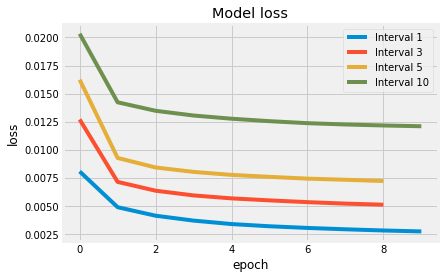

In [13]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

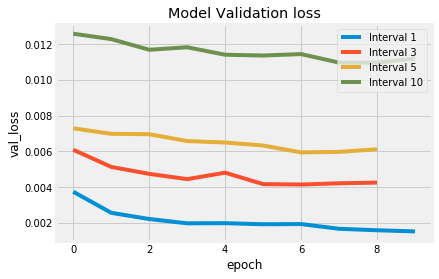

In [14]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
plt.title('Model Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

## Helper function ##

In [15]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [16]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate model #

In [17]:

def make_prediction(data, s, i):
    sc = scaler[s]
    mse = 0
    # Define X_test
    x_test = data[s]['X'][i]
    X_test = np.array(x_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define y_true
    y_test = data[s]['Y'][i]
    Y_test = np.array(y_test)
    Y_test = Y_test.reshape(-1,1)
    y_true = sc.inverse_transform(Y_test)

    # Predicting
    result = model[i].predict(X_test)
    y_pred = sc.inverse_transform(result)

    # Calculate MSE
    mse = return_mse(y_true, y_pred)
    return y_true, y_pred, mse

## Predicting on Train Set

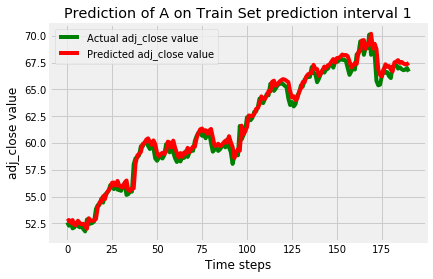

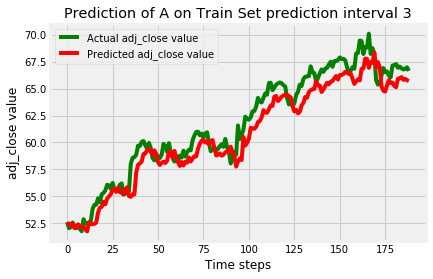

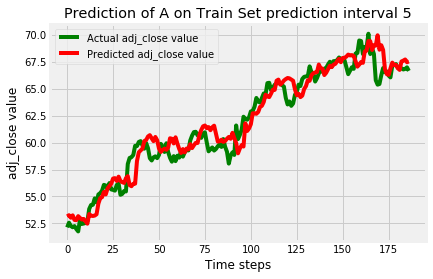

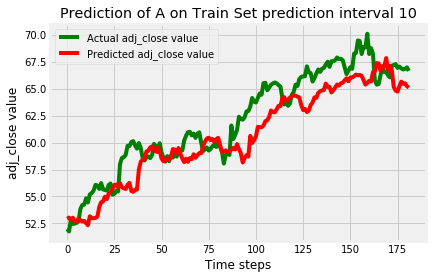

In [22]:
mse_val = {}
for i in prediction_intervals:
    # Predicting
    s = 'A'
    y_true, y_pred, mse = make_prediction(train_set, s, i)
    mse_val[i] = mse
    # Plotting graph
    plotting_graph(y_true, y_pred, s, 'Train Set prediction interval {}'.format(i))

In [23]:
for i in mse_val:
    print('Train Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Train Set -> MSE of A inveral 1: 0.46145910260010525
Train Set -> MSE of A inveral 3: 1.9296529988817392
Train Set -> MSE of A inveral 5: 1.5289981529570458
Train Set -> MSE of A inveral 10: 4.349024396944537


## Predicting on Test Set

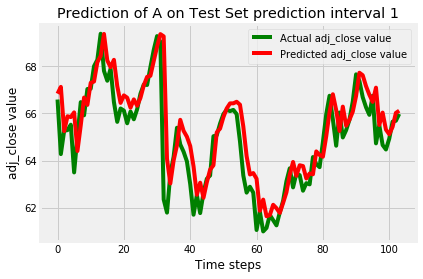

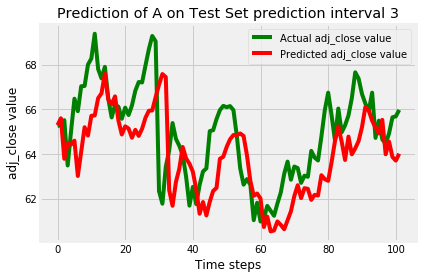

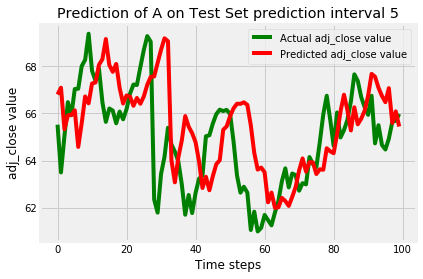

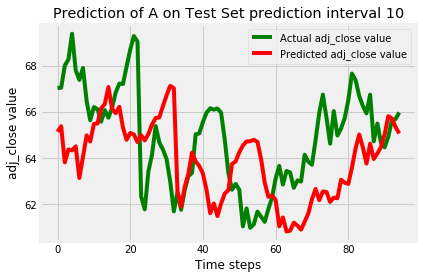

In [24]:
mse_val = {}
for i in prediction_intervals:
    # Predicting
    s = 'A'
    y_true, y_pred, mse = make_prediction(test_set, s, i)
    mse_val[i] = mse
    # Plotting graph
    plotting_graph(y_true, y_pred, s, 'Test Set prediction interval {}'.format(i))

In [25]:
for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of A inveral 1: 1.3460057435768347
Test Set -> MSE of A inveral 3: 3.7312509996514587
Test Set -> MSE of A inveral 5: 4.448682700724465
Test Set -> MSE of A inveral 10: 6.56017883573827
